##### Copyright 2024 The AI Edge Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Human Pose Classification with MoveNet and TensorFlow Lite

This notebook teaches you how to train a pose classification model using MoveNet and TensorFlow Lite. The result is a new TensorFlow Lite model that accepts the output from the MoveNet model as its input, and outputs a pose classification, such as the name of a yoga pose.

The procedure in this notebook consists of 3 parts:
* Part 1: Preprocess the pose classification training data into a CSV file that specifies the landmarks (body keypoints) detected by the MoveNet model, along with the ground truth pose labels.
* Part 2: Build and train a pose classification model that takes the landmark coordinates from the CSV file as input, and outputs the predicted labels.
* Part 3: Convert the pose classification model to TFLite.

By default, this notebook uses an image dataset with labeled yoga poses, but we've also included a section in Part 1 where you can upload your own image dataset of poses.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/tutorials/pose_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/tutorials/pose_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/tutorials/pose_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/tensorflow/lite/g3doc/tutorials/pose_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/s?q=movenet"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

## Preparation

In this section, you'll import the necessary libraries and define several functions to preprocess the training images into a CSV file that contains the landmark coordinates and ground truth labels.

Nothing observable happens here, but you can expand the hidden code cells to see the implementation for some of the functions we'll be calling later on.

**If you only want to create the CSV file without knowing all the details, just run this section and proceed to Part 1.**

In [1]:
%pip install -q opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scikit-learn

  Using cached scipy-1.13.1-cp39-cp39-macosx_12_0_arm64.whl.metadata (60 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 37.9 MB/s eta 0:00:00 0:00:01
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached scipy-1.13.1-cp39-cp39-macosx_12_0_arm64.whl (30.3 MB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

/Users/krishnagupta/Desktop/TeamBaddiCoach/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Code to run pose estimation using MoveNet

In [2]:
#@title Functions to run pose estimation with MoveNet

#@markdown You'll download the MoveNet Thunder model from [TensorFlow Hub](https://www.google.com/url?sa=D&q=https%3A%2F%2Ftfhub.dev%2Fs%3Fq%3Dmovenet), and reuse some inference and visualization logic from the [MoveNet Raspberry Pi (Python)](https://github.com/tensorflow/examples/tree/master/lite/examples/pose_estimation/raspberry_pi) sample app to detect landmarks (ear, nose, wrist etc.) from the input images.

#@markdown *Note: You should use the most accurate pose estimation model (i.e. MoveNet Thunder) to detect the keypoints and use them to train the pose classification model to achieve the best accuracy. When running inference, you can use a pose estimation model of your choice (e.g. either MoveNet Lightning or Thunder).*

# Download model from TF Hub and check out inference code from GitHub
#!wget -q -O movenet_thunder.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
!wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
!git clone https://github.com/tensorflow/examples.git
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

# Load MoveNet Thunder model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('/Users/krishnagupta/Desktop/TeamBaddiCoach/baddi-coach/backend/new.tflite')

# Define function to run pose estimation using MoveNet Thunder.
# You'll apply MoveNet's cropping algorithm and run inference multiple times on
# the input image to improve pose estimation accuracy.
def detect(input_tensor, inference_count=3):
  """Runs detection on an input image.

  Args:
    input_tensor: A [height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.
    inference_count: Number of times the model should run repeatly on the
      same input image to improve detection accuracy.

  Returns:
    A Person entity detected by the MoveNet.SinglePose.
  """
  image_height, image_width, channel = input_tensor.shape

  # Detect pose using the full input image
  movenet.detect(input_tensor.numpy(), reset_crop_region=True)

  # Repeatedly using previous detection result to identify the region of
  # interest and only croping that region to improve detection accuracy
  for _ in range(inference_count - 1):
    person = movenet.detect(input_tensor.numpy(),
                            reset_crop_region=False)

  return person

zsh:1: no matches found: https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
Cloning into 'examples'...
remote: Enumerating objects: 24200, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 24200 (delta 2), reused 6 (delta 0), pack-reused 24184 (from 2)
Receiving objects: 100% (24200/24200), 44.21 MiB | 31.03 MiB/s, done.
Resolving deltas: 100% (13155/13155), done.


/Users/krishnagupta/Desktop/TeamBaddiCoach/.venv/lib/python3.9/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [3]:
#@title Functions to visualize the pose estimation results.

def draw_prediction_on_image(
    image, person, crop_region=None, close_figure=True,
    keep_input_size=False):
  """Draws the keypoint predictions on image.

  Args:
    image: An numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    person: A person entity returned from the MoveNet.SinglePose model.
    close_figure: Whether to close the plt figure after the function returns.
    keep_input_size: Whether to keep the size of the input image.

  Returns:
    An numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  # Draw the detection result on top of the image.
  image_np = utils.visualize(image, [person])

  # Plot the image with detection results.
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  im = ax.imshow(image_np)

  if close_figure:
    plt.close(fig)

  if not keep_input_size:
    image_np = utils.keep_aspect_ratio_resizer(image_np, (512, 512))

  return image_np

In [22]:
import os
import sys
import csv
import tempfile

import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import tqdm

# You must have these implemented/imported elsewhere in your codebase:
#   detect(image) → returns a `person` object with `keypoints`
#   draw_prediction_on_image(img, person, close_figure, keep_input_size)
#   BodyPart  → an enum of keypoint names

class MoveNetPreprocessor(object):
    """Helper class to preprocess pose sample images for classification."""

    def __init__(self,
                 images_in_folder: str,
                 images_out_folder: str,
                 csvs_out_path: str):
        """Creates a preprocessor to detect pose in images and save as CSV.

        Args:
          images_in_folder: Path to input images organized by class subfolders.
          images_out_folder: Path to write images overlaid with detected landmarks.
          csvs_out_path: Path to write the combined CSV of landmark coords + labels.
        """
        self._images_in_folder = images_in_folder
        self._images_out_folder = images_out_folder
        self._csvs_out_path = csvs_out_path
        self._messages = []

        # Temporary directory to store per-class CSVs
        self._csvs_out_folder_per_class = tempfile.mkdtemp()

        # List of pose class names (subfolders)
        self._pose_class_names = sorted(
            [n for n in os.listdir(self._images_in_folder)
             if not n.startswith('.')]
        )

    def process(self,
                per_pose_class_limit: int = None,
                detection_threshold: float = 0.1):
        """Preprocesses images in the given folder into landmark CSVs/images.

        Args:
          per_pose_class_limit: Max images per class (for speeding up tests).
          detection_threshold: Minimum landmark confidence to accept an image.
        """
        for pose_class_name in self._pose_class_names:
            print(f'Preprocessing "{pose_class_name}"', file=sys.stderr)

            images_in_folder = os.path.join(self._images_in_folder,
                                            pose_class_name)
            images_out_folder = os.path.join(self._images_out_folder,
                                             pose_class_name)
            csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                        f'{pose_class_name}.csv')
            os.makedirs(images_out_folder, exist_ok=True)

            with open(csv_out_path, 'w', newline='') as csv_out_file:
                csv_out_writer = csv.writer(csv_out_file,
                                            delimiter=',',
                                            quoting=csv.QUOTE_MINIMAL)

                image_names = sorted(
                    [n for n in os.listdir(images_in_folder)
                     if not n.startswith('.')])
                if per_pose_class_limit is not None:
                    image_names = image_names[:per_pose_class_limit]

                valid_image_count = 0

                for image_name in tqdm.tqdm(image_names):
                    image_path = os.path.join(images_in_folder, image_name)

                    try:
                        image = tf.io.read_file(image_path)
                        image = tf.io.decode_jpeg(image)
                    except Exception:
                        self._messages.append(f'Skipped {image_path}. Invalid image.')
                        continue

                    if image.shape[-1] != 3:
                        self._messages.append(
                            f'Skipped {image_path}. Not RGB.')
                        continue

                    person = detect(image)

                    # Check all keypoints pass confidence threshold
                    min_score = min(kp.score for kp in person.keypoints)
                    if min_score < detection_threshold:
                        self._messages.append(
                            f'Skipped {image_path}. Low confidence.')
                        continue

                    valid_image_count += 1

                    # Debug image with overlay
                    overlay = draw_prediction_on_image(
                        image.numpy().astype(np.uint8),
                        person,
                        close_figure=True,
                        keep_input_size=True)
                    output_bgr = cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR)
                    cv2.imwrite(os.path.join(images_out_folder,
                                             image_name),
                                output_bgr)

                    # Extract landmarks (x, y, score)
                    pose_landmarks = np.array(
                        [[kp.coordinate.x, kp.coordinate.y, kp.score]
                         for kp in person.keypoints],
                        dtype=np.float32)

                    # Flatten and convert to strings (use built-in str instead of np.str)
                    coordinates = pose_landmarks.flatten().astype(str).tolist()
                    csv_out_writer.writerow([image_name] + coordinates)

                if valid_image_count == 0:
                    raise RuntimeError(
                        f'No valid images found for class "{pose_class_name}".')

        # Print any warnings
        if self._messages:
            print('\n'.join(self._messages), file=sys.stderr)

        # Merge all per-class CSVs into one DataFrame and save
        df_all = self._all_landmarks_as_dataframe()
        df_all.to_csv(self._csvs_out_path, index=False)
        print(f"Combined CSV written to {self._csvs_out_path}")

    def class_names(self):
        """Returns the list of pose class names."""
        return self._pose_class_names

    def _all_landmarks_as_dataframe(self) -> pd.DataFrame:
        """Merges per-class CSVs into a single DataFrame with proper headers."""
        total_df = None

        for idx, class_name in enumerate(self._pose_class_names):
            csv_path = os.path.join(self._csvs_out_folder_per_class,
                                    f'{class_name}.csv')
            df = pd.read_csv(csv_path, header=None)

            # Add label columns
            df['class_no'] = idx
            df['class_name'] = class_name

            # Prepend folder name to the file_name column
            df.iloc[:, 0] = df.iloc[:, 0].apply(
                lambda fn: os.path.join(class_name, fn))

            if total_df is None:
                total_df = df
            else:
                total_df = pd.concat([total_df, df], ignore_index=True)

        # Build header names: file_name + one column per landmark coordinate/score
        cols = ['file_name']
        for bp in BodyPart:
            cols += [f'{bp.name}_x', f'{bp.name}_y', f'{bp.name}_score']
        cols += ['class_no', 'class_name']

        total_df.columns = cols
        return total_df


--2025-04-19 00:09:57--  https://cdn.pixabay.com/photo/2017/03/03/17/30/yoga-2114512_960_720.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 2606:4700:4400::6812:2860, 2606:4700:4400::ac40:93a0, 172.64.147.160, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|2606:4700:4400::6812:2860|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29588 (29K) [image/jpeg]
Saving to: ‘/tmp/image.jpeg’

/tmp/image.jpeg     100%[===================>]  28.89K  --.-KB/s    in 0.005s  

2025-04-19 00:09:58 (6.00 MB/s) - ‘/tmp/image.jpeg’ saved [29588/29588]



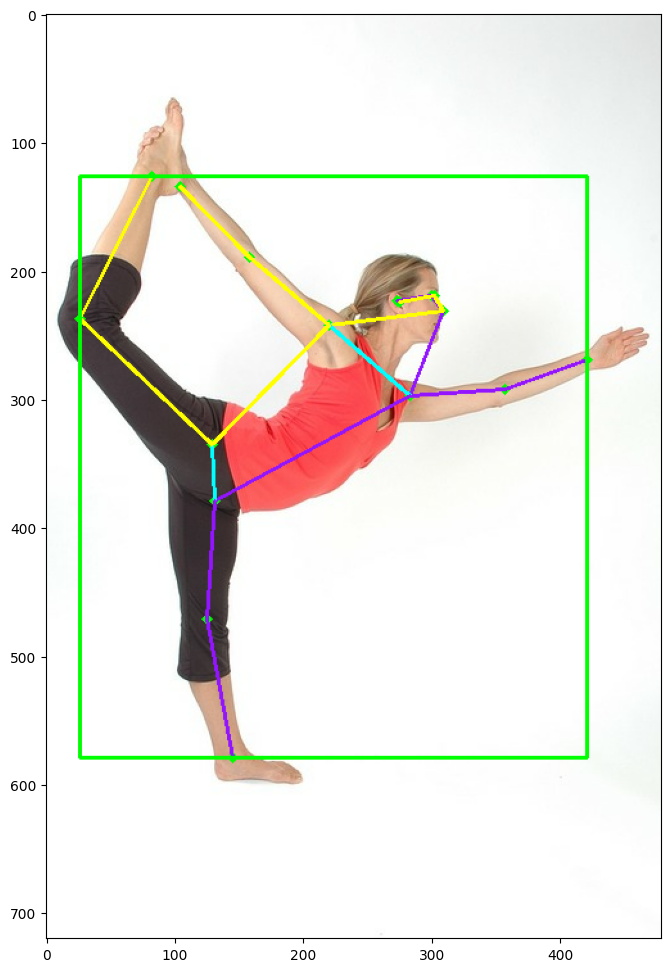

In [5]:
#@title (Optional) Code snippet to try out the Movenet pose estimation logic

#@markdown You can download an image from the internet, run the pose estimation logic on it and plot the detected landmarks on top of the input image.

#@markdown *Note: This code snippet is also useful for debugging when you encounter an image with bad pose classification accuracy. You can run pose estimation on the image and see if the detected landmarks look correct or not before investigating the pose classification logic.*

test_image_url = "https://cdn.pixabay.com/photo/2017/03/03/17/30/yoga-2114512_960_720.jpg" #@param {type:"string"}
!wget -O /tmp/image.jpeg {test_image_url}

if len(test_image_url):
  image = tf.io.read_file('/tmp/image.jpeg')
  image = tf.io.decode_jpeg(image)
  person = detect(image)
  _ = draw_prediction_on_image(image.numpy(), person, crop_region=None,
                               close_figure=False, keep_input_size=True)

## Part 1: Preprocess the input images

Because the input for our pose classifier is the *output* landmarks from the MoveNet model, we need to generate our training dataset by running labeled images through MoveNet and then capturing all the landmark data and ground truth labels into a CSV file.

The dataset we've provided for this tutorial is a CG-generated yoga pose dataset. It contains images of multiple CG-generated models doing 5 different yoga poses. The directory is already split into a `train` dataset and a `test` dataset.

So in this section, we'll download the yoga dataset and run it through MoveNet so we can capture all the landmarks into a CSV file... **However, it takes about 15 minutes to feed our yoga dataset to MoveNet and generate this CSV file**. So as an alternative, you can download a pre-existing CSV file for the yoga dataset by setting `is_skip_step_1` parameter below to **True**. That way, you'll skip this step and instead download the same CSV file that will be created in this preprocessing step.

On the other hand, if you want to train the pose classifier with your own image dataset, you need to upload your images and run this preprocessing step (leave `is_skip_step_1` **False**)—follow the instructions below to upload your own pose dataset.

In [6]:
is_skip_step_1 = False #@param ["False", "True"] {type:"raw"}

### (Optional) Upload your own pose dataset

In [7]:
use_custom_dataset = True #@param ["False", "True"] {type:"raw"}

dataset_is_split = True #@param ["False", "True"] {type:"raw"}

If you want to train the pose classifier with your own labeled poses (they can be any poses, not just yoga poses), follow these steps:

1. Set the above `use_custom_dataset` option to **True**.

2. Prepare an archive file (ZIP, TAR, or other) that includes a folder with your images dataset. The folder must include sorted images of your poses as follows.

  If you've already split your dataset into train and test sets, then set `dataset_is_split` to **True**. That is, your images folder must include "train" and "test" directories like this:

    ```
    yoga_poses/
    |__ train/
        |__ downdog/
            |______ 00000128.jpg
            |______ ...
    |__ test/
        |__ downdog/
            |______ 00000181.jpg
            |______ ...
    ```

    Or, if your dataset is NOT split yet, then set
    `dataset_is_split` to **False** and we'll split it up based
    on a specified split fraction. That is, your uploaded images
    folder should look like this:

    ```
    yoga_poses/
    |__ downdog/
        |______ 00000128.jpg
        |______ 00000181.jpg
        |______ ...
    |__ goddess/
        |______ 00000243.jpg
        |______ 00000306.jpg
        |______ ...
    ```
3. Click the **Files** tab on the left (folder icon) and then click **Upload to session storage** (file icon).
4. Select your archive file and wait until it finishes uploading before you proceed.
5. Edit the following code block to specify the name of your archive file and images directory. (By default, we expect a ZIP file, so you'll need to also modify that part if your archive is another format.)
6. Now run the rest of the notebook.

In [15]:
#@markdown Be sure you run this cell. It's hiding the `split_into_train_test()` function that's called in the next code block.

import os
import random
import shutil

def split_into_train_test(images_origin, images_dest, test_split):
  """Splits a directory of sorted images into training and test sets.

  Args:
    images_origin: Path to the directory with your images. This directory
      must include subdirectories for each of your labeled classes. For example:
      yoga_poses/
      |__ downdog/
          |______ 00000128.jpg
          |______ 00000181.jpg
          |______ ...
      |__ goddess/
          |______ 00000243.jpg
          |______ 00000306.jpg
          |______ ...
      ...
    images_dest: Path to a directory where you want the split dataset to be
      saved. The results looks like this:
      split_yoga_poses/
      |__ train/
          |__ downdog/
              |______ 00000128.jpg
              |______ ...
      |__ test/
          |__ downdog/
              |______ 00000181.jpg
              |______ ...
    test_split: Fraction of data to reserve for test (float between 0 and 1).
  """
  _, dirs, _ = next(os.walk(images_origin))

  TRAIN_DIR = os.path.join(images_dest, 'train')
  TEST_DIR = os.path.join(images_dest, 'test')
  os.makedirs(TRAIN_DIR, exist_ok=True)
  os.makedirs(TEST_DIR, exist_ok=True)

  for dir in dirs:
    # Get all filenames for this dir, filtered by filetype
    filenames = os.listdir(os.path.join(images_origin, dir))
    filenames = [os.path.join(images_origin, dir, f) for f in filenames if (
        f.endswith('.png') or f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.bmp'))]
    # Shuffle the files, deterministically
    filenames.sort()
    random.seed(42)
    random.shuffle(filenames)
    # Divide them into train/test dirs
    os.makedirs(os.path.join(TEST_DIR, dir), exist_ok=True)
    os.makedirs(os.path.join(TRAIN_DIR, dir), exist_ok=True)
    test_count = int(len(filenames) * test_split)
    for i, file in enumerate(filenames):
      if i < test_count:
        destination = os.path.join(TEST_DIR, dir, os.path.split(file)[1])
      else:
        destination = os.path.join(TRAIN_DIR, dir, os.path.split(file)[1])
      shutil.copyfile(file, destination)
    print(f'Moved {test_count} of {len(filenames)} from class "{dir}" into test.')
  print(f'Your split dataset is in "{images_dest}"')

In [23]:
if use_custom_dataset:
  # ATTENTION:
  # You must edit these two lines to match your archive and images folder name:
  # !tar -xf YOUR_DATASET_ARCHIVE_NAME.tar
  # !unzip -q YOUR_DATASET_ARCHIVE_NAME.zip
  dataset_in = '/Users/krishnagupta/Desktop/TeamBaddiCoach/data'

  # You can leave the rest alone:
  if not os.path.isdir(dataset_in):
    raise Exception("dataset_in is not a valid directory")
  if dataset_is_split:
    IMAGES_ROOT = dataset_in
  else:
    dataset_out = 'split_' + dataset_in
    split_into_train_test(dataset_in, dataset_out, test_split=0.2)
    IMAGES_ROOT = dataset_out

In [17]:
import os
import random
import shutil

def split_into_train_test(images_origin: str, images_dest: str, test_split: float):
    """
    Splits a directory of images (organized in class‑subfolders) into train/test sets.

    Args:
      images_origin: Path to the directory with your images. This directory must
        include one subdirectory per class, each containing that class’s images.
      images_dest: Path to a directory where you want the split dataset saved.
        It will create `train/` and `test/` subfolders, each mirroring the class
        subfolder structure.
      test_split: Fraction in [0,1] of each class’s images to reserve for test.
    """
    # Get list of class subdirectories
    _, class_dirs, _ = next(os.walk(images_origin))

    train_root = os.path.join(images_dest, 'train')
    test_root  = os.path.join(images_dest, 'test')
    os.makedirs(train_root, exist_ok=True)
    os.makedirs(test_root, exist_ok=True)

    for cls in class_dirs:
        src_dir = os.path.join(images_origin, cls)
        # Collect image files
        files = [
            f for f in sorted(os.listdir(src_dir))
            if f.lower().endswith(('.png','.jpg','.jpeg','.bmp','.gif'))
        ]
        # Shuffle deterministically
        random.seed(42)
        random.shuffle(files)

        # Compute split index
        n_test = int(len(files) * test_split)

        # Ensure destination subfolders exist
        os.makedirs(os.path.join(train_root, cls), exist_ok=True)
        os.makedirs(os.path.join(test_root,  cls), exist_ok=True)

        # Copy files
        for i, fname in enumerate(files):
            src_path = os.path.join(src_dir, fname)
            if i < n_test:
                dst_dir = os.path.join(test_root, cls)
            else:
                dst_dir = os.path.join(train_root, cls)
            dst_path = os.path.join(dst_dir, fname)
            shutil.copy2(src_path, dst_path)

        print(f'Class "{cls}": {n_test}/{len(files)} files → test, {len(files)-n_test} → train.')

    print(f'\nDone! Split dataset written to "{images_dest}".')



if __name__ == "__main__":
    # === USER CONFIGURATION ===
    IMAGES_ORIGIN = "/Users/krishnagupta/Desktop/TeamBaddiCoach/data"    # e.g. "/mnt/data/images"
    IMAGES_DEST   = "/Users/krishnagupta/Desktop/TeamBaddiCoach/data_new"        # e.g. "/mnt/data/images_split"
    TEST_SPLIT    = 0.2                             # 20% for test, 80% for train

    split_into_train_test(IMAGES_ORIGIN, IMAGES_DEST, TEST_SPLIT)


Class "smash": 85/425 files → test, 340 → train.
Class "offense": 85/426 files → test, 341 → train.
Class "defense": 87/439 files → test, 352 → train.
Class "serve": 92/464 files → test, 372 → train.
Class "lift": 86/434 files → test, 348 → train.
Class "backhand-general": 86/430 files → test, 344 → train.

Done! Split dataset written to "/Users/krishnagupta/Desktop/TeamBaddiCoach/data_new".


**Note:** If you're using `split_into_train_test()` to split the dataset, it expects all images to be PNG, JPEG, or BMP—it ignores other file types.

### Download the yoga dataset

In [ ]:
if not is_skip_step_1 and not use_custom_dataset:
  !wget -O yoga_poses.zip http://download.tensorflow.org/data/pose_classification/yoga_poses.zip
  !unzip -q yoga_poses.zip -d yoga_cg
  IMAGES_ROOT = "yoga_cg"

### Preprocess the `TRAIN` dataset

In [24]:
IMAGES_ROOT="/Users/krishnagupta/Desktop/TeamBaddiCoach/data_new"
if not is_skip_step_1:
  images_in_train_folder = os.path.join(IMAGES_ROOT, 'train')
  images_out_train_folder = 'poses_images_out_train'
  csvs_out_train_path = 'train_data.csv'

  preprocessor = MoveNetPreprocessor(
      images_in_folder=images_in_train_folder,
      images_out_folder=images_out_train_folder,
      csvs_out_path=csvs_out_train_path,
  )

  preprocessor.process(per_pose_class_limit=None)

Preprocessing "backhand-general"
100%|██████████| 344/344 [00:18<00:00, 19.07it/s]
Preprocessing "defense"
100%|██████████| 352/352 [00:18<00:00, 18.86it/s]
Preprocessing "lift"
100%|██████████| 348/348 [00:18<00:00, 18.85it/s]
Preprocessing "offense"
100%|██████████| 341/341 [00:18<00:00, 18.65it/s]
Preprocessing "serve"
100%|██████████| 372/372 [00:18<00:00, 20.32it/s]
Preprocessing "smash"
100%|██████████| 340/340 [00:18<00:00, 18.33it/s]

Combined CSV written to train_data.csv



Skipped /Users/krishnagupta/Desktop/TeamBaddiCoach/data_new/train/backhand-general/151.jpg. Low confidence.
Skipped /Users/krishnagupta/Desktop/TeamBaddiCoach/data_new/train/backhand-general/155.jpg. Low confidence.
Skipped /Users/krishnagupta/Desktop/TeamBaddiCoach/data_new/train/backhand-general/180.jpg. Low confidence.
Skipped /Users/krishnagupta/Desktop/TeamBaddiCoach/data_new/train/backhand-general/200.jpg. Low confidence.
Skipped /Users/krishnagupta/Desktop/TeamBaddiCoach/data_new/train/backhand-general/201.jpg. Low confidence.
Skipped /Users/krishnagupta/Desktop/TeamBaddiCoach/data_new/train/backhand-general/202.jpg. Low confidence.
Skipped /Users/krishnagupta/Desktop/TeamBaddiCoach/data_new/train/backhand-general/203.jpg. Low confidence.
Skipped /Users/krishnagupta/Desktop/TeamBaddiCoach/data_new/train/backhand-general/204.jpg. Low confidence.
Skipped /Users/krishnagupta/Desktop/TeamBaddiCoach/data_new/train/backhand-general/205.jpg. Low confidence.
Skipped /Users/krishnagupta

### Preprocess the `TEST` dataset

In [25]:
IMAGES_ROOT="/Users/krishnagupta/Desktop/TeamBaddiCoach/data_new"
if not is_skip_step_1:
  images_in_test_folder = os.path.join(IMAGES_ROOT, 'test')
  images_out_test_folder = 'poses_images_out_test'
  csvs_out_test_path = 'test_data.csv'

  preprocessor = MoveNetPreprocessor(
      images_in_folder=images_in_test_folder,
      images_out_folder=images_out_test_folder,
      csvs_out_path=csvs_out_test_path,
  )

  preprocessor.process(per_pose_class_limit=None)

Preprocessing "backhand-general"
100%|██████████| 86/86 [00:04<00:00, 19.63it/s]
Preprocessing "defense"
100%|██████████| 87/87 [00:04<00:00, 18.33it/s]
Preprocessing "lift"
100%|██████████| 86/86 [00:06<00:00, 13.71it/s]
Preprocessing "offense"
100%|██████████| 85/85 [00:04<00:00, 17.67it/s]
Preprocessing "serve"
100%|██████████| 92/92 [00:04<00:00, 20.89it/s]
Preprocessing "smash"
100%|██████████| 85/85 [00:04<00:00, 18.28it/s]

Combined CSV written to test_data.csv



Skipped /Users/krishnagupta/Desktop/TeamBaddiCoach/data_new/test/backhand-general/207.jpg. Low confidence.
Skipped /Users/krishnagupta/Desktop/TeamBaddiCoach/data_new/test/backhand-general/213.jpg. Low confidence.
Skipped /Users/krishnagupta/Desktop/TeamBaddiCoach/data_new/test/backhand-general/215.jpg. Low confidence.
Skipped /Users/krishnagupta/Desktop/TeamBaddiCoach/data_new/test/backhand-general/219.jpg. Low confidence.
Skipped /Users/krishnagupta/Desktop/TeamBaddiCoach/data_new/test/backhand-general/224.jpg. Low confidence.
Skipped /Users/krishnagupta/Desktop/TeamBaddiCoach/data_new/test/backhand-general/261.jpg. Low confidence.
Skipped /Users/krishnagupta/Desktop/TeamBaddiCoach/data_new/test/backhand-general/278.jpg. Low confidence.
Skipped /Users/krishnagupta/Desktop/TeamBaddiCoach/data_new/test/backhand-general/29.jpg. Low confidence.
Skipped /Users/krishnagupta/Desktop/TeamBaddiCoach/data_new/test/backhand-general/34.jpg. Low confidence.
Skipped /Users/krishnagupta/Desktop/Te

## Part 2: Train a pose classification model that takes the landmark coordinates as input, and output the predicted labels.

You'll build a TensorFlow model that takes the landmark coordinates and predicts the pose class that the person in the input image performs. The model consists of two submodels:

* Submodel 1 calculates a pose embedding (a.k.a feature vector) from the detected landmark coordinates.
* Submodel 2 feeds pose embedding through several `Dense` layer to predict the pose class.

You'll then train the model based on the dataset that were preprocessed in part 1.

### (Optional) Download the preprocessed dataset if you didn't run part 1

In [ ]:
# Download the preprocessed CSV files which are the same as the output of step 1
if is_skip_step_1:
  !wget -O train_data.csv http://download.tensorflow.org/data/pose_classification/yoga_train_data.csv
  !wget -O test_data.csv http://download.tensorflow.org/data/pose_classification/yoga_test_data.csv

  csvs_out_train_path = 'train_data.csv'
  csvs_out_test_path = 'test_data.csv'
  is_skipped_step_1 = True

### Load the preprocessed CSVs into `TRAIN` and `TEST` datasets.

In [26]:
def load_pose_landmarks(csv_path):
  """Loads a CSV created by MoveNetPreprocessor.

  Returns:
    X: Detected landmark coordinates and scores of shape (N, 17 * 3)
    y: Ground truth labels of shape (N, label_count)
    classes: The list of all class names found in the dataset
    dataframe: The CSV loaded as a Pandas dataframe features (X) and ground
      truth labels (y) to use later to train a pose classification model.
  """

  # Load the CSV file
  dataframe = pd.read_csv(csv_path)
  df_to_process = dataframe.copy()

  # Drop the file_name columns as you don't need it during training.
  df_to_process.drop(columns=['file_name'], inplace=True)

  # Extract the list of class names
  classes = df_to_process.pop('class_name').unique()

  # Extract the labels
  y = df_to_process.pop('class_no')

  # Convert the input features and labels into the correct format for training.
  X = df_to_process.astype('float64')
  y = keras.utils.to_categorical(y)

  return X, y, classes, dataframe

Load and split the original `TRAIN` dataset into `TRAIN` (85% of the data) and `VALIDATE` (the remaining 15%).

In [27]:
# Load the train data
X, y, class_names, _ = load_pose_landmarks(csvs_out_train_path)

# Split training data (X, y) into (X_train, y_train) and (X_val, y_val)
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.15)

In [28]:
# Load the test data
X_test, y_test, _, df_test = load_pose_landmarks(csvs_out_test_path)

### Define functions to convert the pose landmarks to a pose embedding (a.k.a. feature vector) for pose classification

Next, convert the landmark coordinates to a feature vector by:
1. Moving the pose center to the origin.
2. Scaling the pose so that the pose size becomes 1
3. Flattening these coordinates into a feature vector

Then use this feature vector to train a neural-network based pose classifier.

In [29]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
  """Calculates the center point of the two given landmarks."""

  left = tf.gather(landmarks, left_bodypart.value, axis=1)
  right = tf.gather(landmarks, right_bodypart.value, axis=1)
  center = left * 0.5 + right * 0.5
  return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
  """Calculates pose size.

  It is the maximum of two values:
    * Torso size multiplied by `torso_size_multiplier`
    * Maximum distance from pose center to any pose landmark
  """
  # Hips center
  hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP,
                                 BodyPart.RIGHT_HIP)

  # Shoulders center
  shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

  # Torso size as the minimum body size
  torso_size = tf.linalg.norm(shoulders_center - hips_center)

  # Pose center
  pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP,
                                     BodyPart.RIGHT_HIP)
  pose_center_new = tf.expand_dims(pose_center_new, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to
  # perform substraction
  pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

  # Dist to pose center
  d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
  # Max dist to pose center
  max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

  # Normalize scale
  pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

  return pose_size


def normalize_pose_landmarks(landmarks):
  """Normalizes the landmarks translation by moving the pose center to (0,0) and
  scaling it to a constant pose size.
  """
  # Move landmarks so that the pose center becomes (0,0)
  pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP,
                                 BodyPart.RIGHT_HIP)
  pose_center = tf.expand_dims(pose_center, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to perform
  # substraction
  pose_center = tf.broadcast_to(pose_center,
                                [tf.size(landmarks) // (17*2), 17, 2])
  landmarks = landmarks - pose_center

  # Scale the landmarks to a constant pose size
  pose_size = get_pose_size(landmarks)
  landmarks /= pose_size

  return landmarks


def landmarks_to_embedding(landmarks_and_scores):
  """Converts the input landmarks into a pose embedding."""
  # Reshape the flat input into a matrix with shape=(17, 3)
  reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

  # Normalize landmarks 2D
  landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

  # Flatten the normalized landmark coordinates into a vector
  embedding = keras.layers.Flatten()(landmarks)

  return embedding

### Define a Keras model for pose classification

Our Keras model takes the detected pose landmarks, then calculates the pose embedding and predicts the pose class.

In [30]:
# First define the custom layers
class PoseCenter(keras.layers.Layer):
    def __init__(self, left_bodypart, right_bodypart, **kwargs):
        super().__init__(**kwargs)
        self.left_bodypart = left_bodypart
        self.right_bodypart = right_bodypart

    def call(self, landmarks):
        left = tf.gather(landmarks, self.left_bodypart.value, axis=1)
        right = tf.gather(landmarks, self.right_bodypart.value, axis=1)
        return left * 0.5 + right * 0.5

class NormalizePoseLandmarks(keras.layers.Layer):
    def call(self, landmarks):
        # Get pose center
        pose_center = PoseCenter(BodyPart.LEFT_HIP, BodyPart.RIGHT_HIP)(landmarks)
        pose_center = tf.expand_dims(pose_center, axis=1)

        # Translate to center
        translated_landmarks = landmarks - pose_center

        # Get pose size
        pose_size = tf.sqrt(tf.reduce_sum(tf.square(translated_landmarks), axis=2))
        pose_size = tf.reduce_max(pose_size, axis=1, keepdims=True)
        pose_size = tf.expand_dims(pose_size, axis=2)

        # Normalize
        return translated_landmarks / pose_size

class LandmarksToEmbedding(keras.layers.Layer):
    def call(self, inputs):
        # Reshape the inputs to (batch_size, 17, 3)
        reshaped_inputs = keras.layers.Reshape((17, 3))(inputs)

        # Normalize landmarks 2D
        landmarks = NormalizePoseLandmarks()(reshaped_inputs[:, :, :2])

        # Flatten the normalized landmark coordinates
        return keras.layers.Flatten()(landmarks)

# Now define the model using these layers
inputs = tf.keras.Input(shape=(51,))
embedding = LandmarksToEmbedding()(inputs)
layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)
model = keras.Model(inputs, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 51)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ landmarks_to_embedding          │ (None, 34)             │             0 │
│ (LandmarksToEmbedding)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,126 (51.27 KB)

 Trainable params: 13,126 (51.27 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.best.keras"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=20)

# Start training
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
58/93 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - accuracy: 0.1960 - loss: 1.7982 
Epoch 1: val_accuracy improved from -inf to 0.48473, saving model to weights.best.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2164 - loss: 1.7717 - val_accuracy: 0.4847 - val_loss: 1.5460
Epoch 2/200
67/93 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - accuracy: 0.3592 - loss: 1.5589
Epoch 2: val_accuracy improved from 0.48473 to 0.54580, saving model to weights.best.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3634 - loss: 1.5487 - val_accuracy: 0.5458 - val_loss: 1.3820
Epoch 3/200
69/93 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - accuracy: 0.4433 - loss: 1.4293
Epoch 3: val_accuracy improved from 0.54580 to 0.57252, saving model to weights.best.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4453 - loss: 1.4189 - val_accuracy: 0.5725 - val_loss: 1.2441
Epoch 4/200
76/93 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - accuracy: 0.4688 - loss: 1.3290
Epoch 4: val_accuracy improved from 

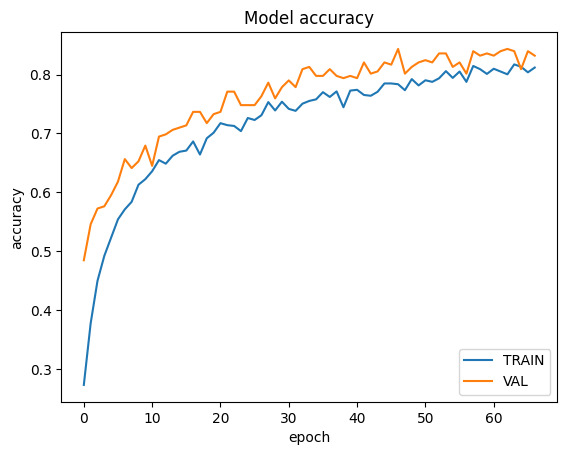

In [32]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [35]:
# Evaluate the model using the TEST dataset
loss, accuracy = model.evaluate(X_test, y_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8632 - loss: 0.4356 


In [36]:
model.save("/Users/krishnagupta/Desktop/TeamBaddiCoach/pose_estimation.tflite")

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/Users/krishnagupta/Desktop/TeamBaddiCoach/pose_estimation.tflite.

### Draw the confusion matrix to better understand the model performance

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """Plots the confusion matrix."""
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=55)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

### (Optional) Investigate incorrect predictions

You can look at the poses from the `TEST` dataset that were incorrectly predicted to see whether the model accuracy can be improved.

Note: This only works if you have run step 1 because you need the pose image files on your local machine to display them.

In [ ]:
if is_skip_step_1:
  raise RuntimeError('You must have run step 1 to run this cell.')

# If step 1 was skipped, skip this step.
IMAGE_PER_ROW = 3
MAX_NO_OF_IMAGE_TO_PLOT = 30

# Extract the list of incorrectly predicted poses
false_predict = [id_in_df for id_in_df in range(len(y_test)) \
                if y_pred_label[id_in_df] != y_true_label[id_in_df]]
if len(false_predict) > MAX_NO_OF_IMAGE_TO_PLOT:
  false_predict = false_predict[:MAX_NO_OF_IMAGE_TO_PLOT]

# Plot the incorrectly predicted images
row_count = len(false_predict) // IMAGE_PER_ROW + 1
fig = plt.figure(figsize=(10 * IMAGE_PER_ROW, 10 * row_count))
for i, id_in_df in enumerate(false_predict):
  ax = fig.add_subplot(row_count, IMAGE_PER_ROW, i + 1)
  image_path = os.path.join(images_out_test_folder,
                            df_test.iloc[id_in_df]['file_name'])

  image = cv2.imread(image_path)
  plt.title("Predict: %s; Actual: %s"
            % (y_pred_label[id_in_df], y_true_label[id_in_df]))
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

## Part 3: Convert the pose classification model to TensorFlow Lite

You'll convert the Keras pose classification model to the TensorFlow Lite format so that you can deploy it to mobile apps, web browsers and edge devices. When converting the model, you'll apply [dynamic range quantization](https://www.tensorflow.org/lite/performance/post_training_quant) to reduce the pose classification TensorFlow Lite model size by about 4 times with insignificant accuracy loss.

Note: TensorFlow Lite supports multiple quantization schemes. See the [documentation](https://www.tensorflow.org/lite/performance/model_optimization) if you are interested to learn more.

In [34]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

print('Model size: %dKB' % (len(tflite_model) / 1024))

with open('pose_classifier.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/dx/mmd7ycv957q019dz2clmbh_w0000gn/T/tmp8_iwniyo/assets


INFO:tensorflow:Assets written to: /var/folders/dx/mmd7ycv957q019dz2clmbh_w0000gn/T/tmp8_iwniyo/assets


Saved artifact at '/var/folders/dx/mmd7ycv957q019dz2clmbh_w0000gn/T/tmp8_iwniyo'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 51), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  14885939504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14885940032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14889813616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14889812208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13512855392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15045996784: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model size: 23KB


W0000 00:00:1745049027.136346 4321063 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1745049027.136381 4321063 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-04-19 00:50:27.136613: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/dx/mmd7ycv957q019dz2clmbh_w0000gn/T/tmp8_iwniyo
2025-04-19 00:50:27.137031: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-04-19 00:50:27.137036: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/dx/mmd7ycv957q019dz2clmbh_w0000gn/T/tmp8_iwniyo
I0000 00:00:1745049027.140436 4321063 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
2025-04-19 00:50:27.140999: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-04-19 00:50:27.161291: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folder

In [37]:
import numpy as np
import tensorflow as tf

# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path='pose_classifier.tflite')
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
# Check the structure of input_details
print("Input details:", input_details)
print("Shape from input details:", input_details[0]['shape'])



Input details: [{'name': 'serving_default_keras_tensor:0', 'index': 0, 'shape': array([ 1, 51], dtype=int32), 'shape_signature': array([-1, 51], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Shape from input details: [ 1 51]


/Users/krishnagupta/Desktop/TeamBaddiCoach/.venv/lib/python3.9/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img


def preprocess_image(image_path, input_size):
    """Load an image and resize it to the target size."""
    img = load_img(image_path, target_size=input_size)
    img_array = img_to_array(img)  # Convert the image to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension
    return img_array

# Example usage
image_path = '/content/warrior.jpeg'
input_size = input_details[0]['shape']  # Assumes (height, width, channels)
processed_image = preprocess_image(image_path, input_size)


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# First load the image properly
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image)

# Get the pose detection (you'll need your detect function here)
person = detect(image)  # You'll need to have this detect function defined

# Now you can use the draw_prediction_on_image function
output_overlay = draw_prediction_on_image(
    image=image.numpy().astype(np.uint8),
    person=person,
    close_figure=True,
    keep_input_size=True
)

# Display the result
plt.figure(figsize=(12, 12))
plt.imshow(output_overlay)
plt.axis('off')
plt.show()

# If you want to save the image
output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)
cv2.imwrite('output_pose.jpg', output_frame)



Then you'll write the label file which contains mapping from the class indexes to the human readable class names.

In [ ]:
with open('pose_labels.txt', 'w') as f:
  f.write('\n'.join(class_names))

As you've applied quantization to reduce the model size, let's evaluate the quantized TFLite model to check whether the accuracy drop is acceptable.

In [38]:

def evaluate_model(interpreter, X, y_true):
    """Evaluates the given TFLite model and returns its accuracy."""
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    y_pred = []  # Store predicted labels

    for i in range(len(y_true)):
        # Pre-processing: add batch dimension and convert to float32
        test_image = X[i: i + 1].astype('float32')
        interpreter.set_tensor(input_index, test_image)

        # Run inference
        interpreter.invoke()

        # Get model output correctly
        output_data = interpreter.get_tensor(output_index)

        # Find the predicted class index
        predicted_label = np.argmax(output_data[0])
        y_pred.append(predicted_label)

        # Print class name along with predicted label
        predicted_class_name = class_names[predicted_label]
        print(f"Sample {i}: Predicted Label = {predicted_label}, Class Name = {predicted_class_name}")

    # Convert y_pred to categorical format and compute accuracy
    y_pred = keras.utils.to_categorical(y_pred, num_classes=len(class_names))
    accuracy = accuracy_score(y_true, y_pred)

    return accuracy

# Load the TFLite model
classifier_interpreter = tf.lite.Interpreter(model_content=tflite_model)
classifier_interpreter.allocate_tensors()

# Evaluate the model
accuracy = evaluate_model(classifier_interpreter, X_test, y_test)

print(f'Accuracy of TFLite model: {accuracy:.4f}')

Sample 0: Predicted Label = 0, Class Name = backhand-general
Sample 1: Predicted Label = 0, Class Name = backhand-general
Sample 2: Predicted Label = 0, Class Name = backhand-general
Sample 3: Predicted Label = 0, Class Name = backhand-general
Sample 4: Predicted Label = 0, Class Name = backhand-general
Sample 5: Predicted Label = 0, Class Name = backhand-general
Sample 6: Predicted Label = 0, Class Name = backhand-general
Sample 7: Predicted Label = 0, Class Name = backhand-general
Sample 8: Predicted Label = 0, Class Name = backhand-general
Sample 9: Predicted Label = 0, Class Name = backhand-general
Sample 10: Predicted Label = 0, Class Name = backhand-general
Sample 11: Predicted Label = 0, Class Name = backhand-general
Sample 12: Predicted Label = 2, Class Name = lift
Sample 13: Predicted Label = 2, Class Name = lift
Sample 14: Predicted Label = 0, Class Name = backhand-general
Sample 15: Predicted Label = 3, Class Name = offense
Sample 16: Predicted Label = 0, Class Name = backha

In [39]:
def predict_pose(interpreter, image_path):
    """Runs inference on a single image and returns the predicted class."""

    # First load and decode the image
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image)

    # Detect pose keypoints from the image
    person = detect(image)  # This gets the pose keypoints

    # Convert keypoints to the format your model expects
    pose_landmarks = np.array(
        [[keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score]
          for keypoint in person.keypoints],
        dtype=np.float32)

    # Reshape to match model input (1, 51) - flattened keypoints
    input_data = pose_landmarks.flatten()
    input_data = np.expand_dims(input_data, axis=0)  # Add batch dimension

    # Get input and output details
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Set input tensor and run inference
    interpreter.set_tensor(input_index, input_data)
    interpreter.invoke()

    # Get model output and find predicted class
    output = interpreter.get_tensor(output_index)[0]
    predicted_label = np.argmax(output)
    predicted_class = class_names[predicted_label]

    return predicted_class, output  # Return both class and raw probabilities

# Load the TFLite model
classifier_interpreter = tf.lite.Interpreter(model_path="/Users/krishnagupta/Desktop/TeamBaddiCoach/baddi-coach/backend/pose_classifier.tflite")
classifier_interpreter.allocate_tensors()

# Predict the pose class for a custom image
predicted_class, probabilities = predict_pose(classifier_interpreter, image_path)

print(f"Predicted Pose Class: {predicted_class}")

/Users/krishnagupta/Desktop/TeamBaddiCoach/.venv/lib/python3.9/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


NameError: name 'image_path' is not defined

In [ ]:
!pip install -q mediapipe

In [ ]:
def process_video_with_pose_classification(input_video_path, output_video_path, movenet, classifier_interpreter, class_names):
    """
    Processes a video by overlaying keypoints and pose classification predictions.

    Args:
        input_video_path (str): Path to the input video file.
        output_video_path (str): Path to save the processed video.
        movenet: The MoveNet model for pose detection.
        classifier_interpreter: The TensorFlow Lite interpreter for pose classification.
        class_names (list): List of class names for pose classification.
    """
    # Open the video file
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file {input_video_path}")
        return

    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Create video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    writer = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

    # Process frames
    frame_count = 0
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"Processing video with {total_frames} frames...")

    try:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            frame_count += 1
            if frame_count % 20 == 0:  # Print progress every 20 frames
                print(f"Processing frame {frame_count}/{total_frames} ({frame_count/total_frames*100:.1f}%)")

            # Convert BGR to RGB (since OpenCV loads as BGR but MoveNet expects RGB)
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Convert the frame to a tensor of type tf.float32
            image_tensor = tf.convert_to_tensor(rgb_frame, dtype=tf.float32)

            # Detect pose in the current frame using the fixed `detect` function
            person = detect(image_tensor)

            # Draw keypoints and add classification text
            if person:
                # Draw keypoints on the frame
                output_overlay = draw_prediction_on_image(
                    rgb_frame, person, close_figure=True, keep_input_size=True
                )

                # Convert keypoints to the format your model expects
                pose_landmarks = np.array(
                    [[keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score]
                     for keypoint in person.keypoints],
                    dtype=np.float32
                )

                # Reshape to match model input (1, 51) - flattened keypoints
                input_data = pose_landmarks.flatten()
                input_data = np.expand_dims(input_data, axis=0)  # Add batch dimension

                # Set input tensor and run inference
                input_index = classifier_interpreter.get_input_details()[0]["index"]
                output_index = classifier_interpreter.get_output_details()[0]["index"]
                classifier_interpreter.set_tensor(input_index, input_data)
                classifier_interpreter.invoke()

                # Get model output and find predicted class
                output = classifier_interpreter.get_tensor(output_index)[0]
                predicted_label = np.argmax(output)
                predicted_class = class_names[predicted_label]

                # Add classification label to the frame
                label = f"{predicted_class} ({output[predicted_label]:.2f})"
                cv2.putText(output_overlay, label, (10, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

                # Convert back to BGR for OpenCV
                output_overlay = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)
            else:
                # If no poses detected, use the original frame
                output_overlay = frame

            # Write frame to output video
            writer.write(output_overlay)

    except Exception as e:
        print(f"Error during video processing: {e}")
        import traceback
        traceback.print_exc()
    finally:
        cap.release()
        writer.release()
        print(f"Processing complete. Output saved to {output_video_path}")

In [ ]:
process_video_with_pose_classification(
    input_video_path="suryanamaskar.mp4",
    output_video_path="output_video.mp4",
    movenet=movenet,
    classifier_interpreter=classifier_interpreter,
    class_names=class_names
)

Now you can download the TFLite model (`pose_classifier.tflite`) and the label file (`pose_labels.txt`) to classify custom poses. See the [Android](https://github.com/tensorflow/examples/tree/master/lite/examples/pose_estimation/android) and [Python/Raspberry Pi](https://github.com/tensorflow/examples/tree/master/lite/examples/pose_estimation/raspberry_pi) sample app for an end-to-end example of how to use the TFLite pose classification model.

In [ ]:
!zip pose_classifier.zip pose_labels.txt pose_classifier.tflite

In [ ]:
# Download the zip archive if running on Colab.
try:
  from google.colab import files
  files.download('pose_classifier.zip')
except:
  pass